# Neural Networks
## Homework 1: Implementing advanced activation functions

**Name**: *Gianmarco Scarano*

**Matricola**: *2047315*

Upload the completed notebook **before 30/11/2022 at 23:59** on the Google Classrom page.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

### Check if we have CUDA support

In [2]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print('Cuda available: {}'.format(torch.cuda.is_available()))
    print("GPU: " + torch.cuda.get_device_name(torch.cuda.current_device()))
    print("Total memory: {:.1f} GB".format((float(torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)))))
    print("===================================================")
else:
    device = torch.device("cpu")
    print('Cuda not available, so using CPU. Please consider switching to a GPU runtime before running the notebook!')

Cuda available: True
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Total memory: 6.0 GB


### Objective

The purpose of this homework is to implement a new layer inside PyTorch, by properly extending the `nn.Module` object. **Before proceeding**, carefully read the following documentation:

+ [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=module#torch.nn.Module)
+ [PyTorch: Custom Module](https://pytorch.org/tutorials/beginner/examples_nn/polynomial_module.html)

You can also (optionally) learn more about activation functions by reading the survey in [1].

### Introduction: families of activation functions

In the course up to now, we have seen the application of the sigmoid, the softmax, and the ReLU. However, many additional activation functions exist [1], with varying strengths and drawbacks.

Several of them are designed as variants of the ReLU. The **S-Shaped ReLU** (SReLU) [2] is defined as:

$$
\phi(s) = \begin{cases} t^r + a^r(s - t^r) & \text{ if } s > t^r \\ s & \text{ if } t^r > s > t^l \\ t^l + a^l(s - t^l) & \text{ if } s < t^l \end{cases} \,.
$$

The four parameters $t^r, a^r, t^l, a^l$ are trained via back-propagation, and they are **different for each unit in the layer**. 


### Exercise 1: implementing an activation function (1 point)

Let us start with the simpler **[exponential linear squashing](https://paperswithcode.com/method/elish)** (ELiSH) activation function:

$$
\phi(x) = \begin{cases} \sigma(x)x & \text{ if } x \ge 0 \\ \frac{\exp(x) - 1}{1 + \exp(-x)} & \text{ otherwise} \end{cases}
$$

**Exercise 1**: complete the following stub.

In [3]:
def elish(x):
  # x is a generic torch.Tensor, and this function must compute the ELiSH activation function.

  ''' 
  torch.where(condition, x, y):
    - condition: BoolTensor | When true (nonzero), returns x, otherwise y.
    - x: Tensor
    - y: Tensor 
  '''
  return torch.where(x >= 0, x * torch.sigmoid(x), (torch.exp(x) - 1) / (1 + torch.exp(-x)))

**Hints for a correct implementation**:

1. There are several ways of implementing an if/else operation like the one above in PyTorch. In general, the simplest implementation of "*if a then b, else c*" is `torch.where(a, b, c)` (see the documentation for [torch.where](https://pytorch.org/docs/stable/generated/torch.where.html)). Any working variant is accepted here.

Here is a simple sanity check for the correct implementation:

In [4]:
elish(torch.FloatTensor([[0.2, -0.4]])) # Should be approximately [[0.11, -0.13]]

tensor([[ 0.1100, -0.1323]])

### Exercise 2: some visualization experiments (1 point)

**Exercise 2.1**: plot the ELiSH function in [-5, +5].

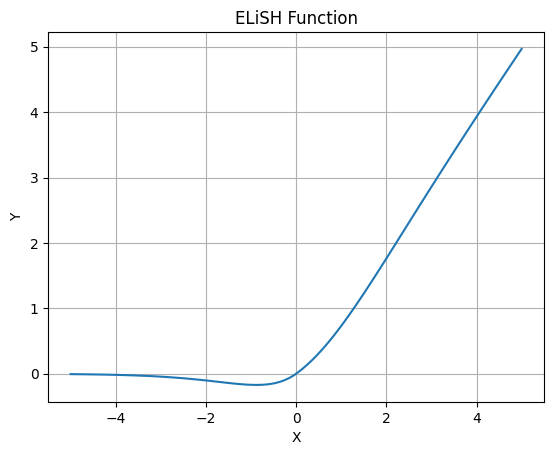

In [5]:
x = torch.linspace(-5, +5, steps=100)
y = elish(x)

plt.figure(dpi=100)
plt.plot(x,y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("ELiSH Function")
plt.grid(visible=True)
plt.show()

**Exercise 2.2**: using the utilities from `torch.autograd` ([torch.autograd](https://pytorch.org/docs/stable/autograd.html)), **compute and plot** the derivative of ELiSH using automatic differentiation.

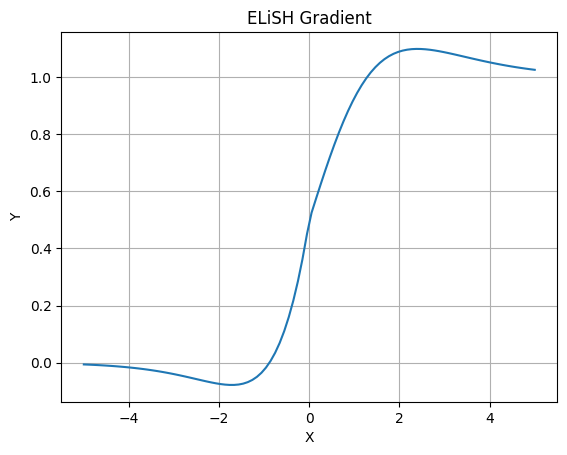

In [6]:
x = torch.linspace(-5, +5, steps=100, requires_grad=True)
y = elish(x)

y.sum().backward() # We compute the gradients

plt.figure(dpi=100)
plt.plot(x.detach().numpy(), x.grad)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("ELiSH Gradient")
plt.grid(visible=True)
plt.show()

**Exercise 2.3 (sanity check)**: build a model using the previously defined activation function, and test it on a random mini-batch of data:

In [7]:
# We build a model by simply calling the elish(x) function on the forward method.
class ELiSHModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        if(input_dim == 0 or input_dim is None):
            raise NotImplementedError("Please specify a input dimension! Use: 'input_dim=x' param")
        
        self.fc1 = nn.Linear(input_dim, 48, device=device)
        self.fc2 = nn.Linear(48, 24, device=device)
        self.fc3 = nn.Linear(24, 1, device=device)
        
    def forward(self, x):
        x = elish(self.fc1(x))
        x = elish(self.fc2(x))
        return self.fc3(x)

In [8]:
randTorch = torch.randn((3, 5), device=device)

model = ELiSHModel(input_dim=randTorch.shape[1])

print(F"randTorch:\n{randTorch}")
print("---------------------------------")
print(F"model(randTorch):\n{model(randTorch)}")

randTorch:
tensor([[-0.3104, -2.1002, -0.6963, -1.6758,  0.8139],
        [ 1.3809, -0.4223,  0.8424, -0.4179, -1.5981],
        [-0.6426,  0.3152, -0.6373,  1.5144, -0.4883]], device='cuda:0')
---------------------------------
model(randTorch):
tensor([[0.0270],
        [0.0177],
        [0.0112]], device='cuda:0', grad_fn=<AddmmBackward0>)


## Exercise 3: implementing a trainable activation function (2 points)

**Exercise 3:** define a `torch.nn.Module` implementing the SReLU.

**Hints for a correct implementation**:
* The layer should **only** implement the activation function. Ideally, it will always be used in combination with a fully-connected layer with no activation function.
* Think carefully about how you want to initialize the parameters.

In [9]:
class SReLU(nn.Module):
  """S-shaped Rectified Linear Unit.
    `f(x) = t^r + a^r(x - t^r) for x >= t^r`,
    `f(x) = x for t^r > x > t^l`,
    `f(x) = t^l + a^l(x - t^l) for x <= t^l`. """
  
  def __init__(self, units, params=None):
    
    super(SReLU, self).__init__()

    self.units = units
    
    # I thought it would be best to initialize the parameters with the variable "units", which corresponds
    # to the number of features of the input tensor. 
    # It means that in our specific case (24 features), the 4 trainable parameters would have shape 1x24. 
    # This, maybe, constraints our problem to be a 1D-dimensional array, but we could also set the rows of the SReLU params
    # to be input.shape[0] (Rows) of our input tensor.
    # In that case, everything would be scalable.
    # Here we also give scalability to the user, in case he wants to pass specific parameters.
    
    # Plus, as for the paper (Page 4 - "Adaptive Initialization of SReLU"), we do initialize the parameters as follows:
    # - t_r = Random number in R
    # - t_l = Tensor of all zeros
    # - a_r = Tensor of all ones
    # - a_l = Tensor of values between 0 and 1
    if params is None:
      self.t_r = torch.randint(low=0, high=5, size=(1,units), dtype=torch.float, device=device, requires_grad=True, ).reshape(-1)
      self.t_l = torch.zeros((1,units), dtype=torch.float, requires_grad=True, device=device).reshape(-1)
      self.a_r = torch.ones(size=(1,units), dtype=torch.float, requires_grad=True, device=device).reshape(-1)
      self.a_l = torch.rand(size=(1,units), dtype=torch.float, requires_grad=True, device=device).reshape(-1)
    else:
      self.t_r, self.t_l, self.a_r, self.a_l = params
      
    # We turn them into nn.Parameters
    self.t_r = nn.Parameter(self.t_r)
    self.t_l = nn.Parameter(self.t_l)
    self.a_r = nn.Parameter(self.a_r)
    self.a_l = nn.Parameter(self.a_l)
      
  def forward(self, x):
    return (
      (x >= self.t_r).float() * (self.t_r + self.a_r * (x + self.t_r))  # First condition  || x >= t^r
      + 
      (self.t_r > x).float() * (x > self.t_l).float() * x               # Second condition || t^r > x > t^l
      + 
      (x <= self.t_l).float() * (self.t_l + self.a_l * (x + self.t_l))  # Third condition  || x <= t^l
    )

As a sanity check, initialize a SReLU layer and count the number of parameters:

In [10]:
# Initialize the layer
params = 0
units = 2

layerSReLU = SReLU(units=units)

# Iterate over the params of the SReLU
for n, p in layerSReLU.named_parameters():  
    print(F"- {n} = {p.data}")
    print("--------------------")
    params += torch.numel(p)
    
print(F"Parameters for SReLU({units}): {params}")

- t_r = tensor([4., 0.], device='cuda:0')
--------------------
- t_l = tensor([0., 0.], device='cuda:0')
--------------------
- a_r = tensor([1., 1.], device='cuda:0')
--------------------
- a_l = tensor([0.2337, 0.8062], device='cuda:0')
--------------------
Parameters for SReLU(2): 8


## Exercise 4: training a model with trainable activation functions (1 point)

We will use the following dataset from TensorFlow Datasets:
https://www.tensorflow.org/datasets/catalog/german_credit_numeric

In [11]:
train_data = tfds.load('german_credit_numeric', split='train[:75%]', as_supervised=True)
test_data = tfds.load('german_credit_numeric', split='train[75%:]', as_supervised=True)

In [12]:
Xtrain, ytrain = train_data.batch(5000).get_single_element()
Xtrain, ytrain = Xtrain.numpy(), ytrain.numpy()

Xtest, ytest = test_data.batch(5000).get_single_element()
Xtest, ytest = Xtest.numpy(), ytest.numpy()

print(F"X[0]: {Xtrain[0,:]}")
print(F"X shape: {Xtrain.shape}")
print(F"y[0]: {ytrain[0]}")
print(F"Y shape: {ytrain.shape}")

X[0]: [ 3  6  4 13  2  5  1  4  3 28  3  2  2  2  1  1  0  1  0  0  1  0  0  1]
X shape: (750, 24)
y[0]: 1
Y shape: (750,)


**Exercise 4**: write a `nn.Module` using the previous `SReLU`, and train it on the german_credit_numeric dataset.

In [13]:
# Pre-processing of data using MinMaxScaler
# We scale feature values between 0 and 1 for the Train/Test set.

scaler = MinMaxScaler()
scaler.fit(Xtrain)
Xtrain = scaler.transform(Xtrain)

scaler = MinMaxScaler()
scaler.fit(Xtest)
Xtest = scaler.transform(Xtest)

print(F"X[0]: {Xtrain[0,:]}")
print(F"X shape: {Xtrain.shape}")
print(F"y[0]: {ytrain[0]}")
print(F"Y shape: {ytrain.shape}")

X[0]: [0.66666667 0.03571429 1.         0.06043956 0.25       1.
 0.         1.         0.66666667 0.16071429 1.         0.33333333
 1.         1.         0.         1.         0.         1.
 0.         0.         1.         0.         0.         1.        ]
X shape: (750, 24)
y[0]: 1
Y shape: (750,)


In [14]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        
        # 24 Features
        self.fc1 = nn.Linear(24, 12, device=device) # 24 Features -> 12 in output
        self.fc2 = nn.Linear(12, 6, device=device) # 12 Features -> 6 in output
        
        # This is the last layer. Basically the prediction
        self.fc3 = nn.Linear(6, 1, device=device) # 6 Features -> 1 in output
        
        # We initialize SReLU with 12 units (FC1) and 6 units (FC2)
        self.srelu12 = SReLU(units=12)
        self.srelu6 = SReLU(units=6)
        
        # Probability of "ignoring" units in a Hidden Layer = 0.2
        self.dropout = nn.Dropout(p = 0.2)
                
    def forward(self, x):
        x = self.fc1(x)
        x = self.srelu12(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.srelu6(x)
        #x = self.dropout(x)
        # I've decided to not add dropout at the output of srelu6, since
        # we do have only 6 values and with p = 0.2, it would mean we would
        # have only 4 values to take into consideration.
        # We could've also initialized another dropout layer with much less probability.
 
        x = self.fc3(x)
        return x.reshape(-1) # We want the single values only, not a list with single values

In [15]:
loss = nn.BCEWithLogitsLoss() # We use BCEWithLogits which is Cross Entropy Loss for Binary Classification + Sigmoid
cnn = LinearModel() # Initalize our model
opt = torch.optim.Adam(cnn.parameters(), lr = 0.0015) # Initialize the Loss function and pass the parameters of our model
epochs = 300

Train function. We specified all the needed variables in the previous cell.

In [16]:
num_correct_train = 0
num_samples_train = 0
num_correct_val = 0
num_samples_val = 0

train_loss_epoch = 0
val_loss_epoch = 0

train_acc_epoch = 0
val_acc_epoch = 0

valAccuracies = []
trainAccuracies = []

trainLosses = []
valLosses = []

for epoch in range(1, epochs+1):
  
  # We put the CNN in training mode
  cnn.train()

  # We iterate over the train set, taking batches of xb, yb.
  xb = torch.tensor(Xtrain, device=device, dtype=torch.float32)
  yb = torch.tensor(ytrain, device=device, dtype=torch.float32)
            
  opt.zero_grad() # We empty the gradients
          
  ypred = cnn(xb) # Actual prediction of our model
  lTrain = loss(ypred, yb) # We perform a Binary Classification Entropy Loss with Logits between the real value and our prediction
  
  lTrain.backward() # We compute the gradients
  opt.step() # Parameters updated -> Single step optimization 
   
  train_loss_epoch = lTrain.item()
  trainLosses.append(train_loss_epoch)
 
  # Accuracy computation
 
  # We round the prediction and:
  # if == ground truth -> Correct prediction
  # if != ground truth -> Wrong prediction
  ypred_tag = torch.round(torch.sigmoid(ypred))

  num_correct_train = (ypred_tag == yb).sum().float()
        
  train_acc_epoch = (num_correct_train/yb.shape[0]).detach().cpu().numpy()
  trainAccuracies.append(train_acc_epoch)

  with torch.no_grad():
    cnn.eval() # We put our model in evaluation mode for testing the accuracy over the test set
     
    # We iterate over the train set, taking batches of xb, yb.
    xb = torch.tensor(Xtest, device=device, dtype=torch.float32)
    yb = torch.tensor(ytest, device=device, dtype=torch.float32)
    
    ypred = cnn(xb)      
    lVal = loss(ypred, yb) # We perform a Binary Classification Entropy Loss with Logits between the real value and our prediction
  
    val_loss_epoch = lVal.item()
    valLosses.append(val_loss_epoch)
  
    # Accuracy computation  
    ypred_tag = torch.round(torch.sigmoid(ypred))
    
    num_correct_val = (ypred_tag == yb).sum().float()
    
    val_acc_epoch = (num_correct_val/yb.shape[0]).detach().cpu().numpy()
    valAccuracies.append(val_acc_epoch)
  
  if (epoch % 100 == 0):
    print(f'Epoch {epoch+0:03}:')     
    print(f'\t- Training accuracy   : {train_acc_epoch:.3f} (avg. {np.average(trainAccuracies):.3f})')
    print(f'\t- Training loss       : {train_loss_epoch:.3f} (avg. {np.average(trainLosses):.3f})')
    print(f'\t- Validation accuracy : {val_acc_epoch:.3f} (avg. {np.average(valAccuracies):.3f})')
    print(f'\t- Validation loss     : {val_loss_epoch:.3f} (avg. {np.average(valLosses):.3f})')
    print("=========================================")

Epoch 100:
	- Training accuracy   : 0.764 (avg. 0.713)
	- Training loss       : 0.495 (avg. 0.566)
	- Validation accuracy : 0.684 (avg. 0.676)
	- Validation loss     : 0.568 (avg. 0.602)
Epoch 200:
	- Training accuracy   : 0.787 (avg. 0.747)
	- Training loss       : 0.443 (avg. 0.512)
	- Validation accuracy : 0.748 (avg. 0.706)
	- Validation loss     : 0.574 (avg. 0.585)
Epoch 300:
	- Training accuracy   : 0.792 (avg. 0.762)
	- Training loss       : 0.436 (avg. 0.488)
	- Validation accuracy : 0.744 (avg. 0.718)
	- Validation loss     : 0.584 (avg. 0.583)


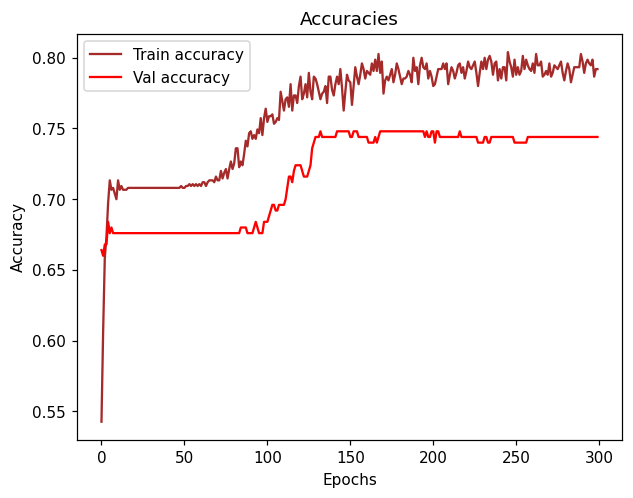

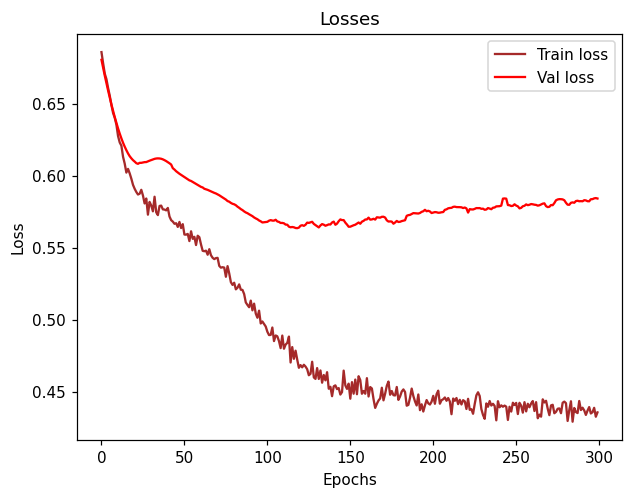

In [17]:
# We plot our results
epochsList = np.arange(0,epochs,1)

plt.figure(dpi=110)
plt.title("Accuracies")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochsList, trainAccuracies, label="Train accuracy", c="brown")
plt.plot(epochsList, valAccuracies, label="Val accuracy", c="red")
plt.legend()
plt.show()

plt.figure(dpi=110)
plt.title("Losses")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochsList, trainLosses, label="Train loss", c="brown")
plt.plot(epochsList, valLosses, label="Val loss", c="red")
plt.legend()
plt.show()

**Optionally**, you can plot the distribution (histogram) of the parameters after training.

Name: srelu12.t_r | torch.Size([12])
Parameter containing:
tensor([2.0000, 3.0000, 0.2342, 2.0000, 2.0000, 0.1833, 3.0000, 4.0000, 0.0110,
        2.0000, 0.0223, 0.7182], device='cuda:0', requires_grad=True)
----------------
Name: srelu12.t_l | torch.Size([12])
Parameter containing:
tensor([-0.2943, -0.5621, -0.2793, -0.0037, -0.0058, -0.0721, -0.2426, -0.3525,
        -0.0612, -0.0433, -0.0381, -0.2156], device='cuda:0',
       requires_grad=True)
----------------
Name: srelu12.a_r | torch.Size([12])
Parameter containing:
tensor([1.0000, 1.0000, 1.2594, 1.0000, 1.0000, 1.2759, 1.0000, 1.0000, 0.9263,
        1.0000, 0.7960, 0.7227], device='cuda:0', requires_grad=True)
----------------
Name: srelu12.a_l | torch.Size([12])
Parameter containing:
tensor([1.2658, 1.5269, 0.8422, 0.7679, 0.7247, 0.7217, 0.5870, 0.7937, 1.0828,
        0.8774, 1.0543, 0.8678], device='cuda:0', requires_grad=True)
----------------
Name: srelu6.t_r | torch.Size([6])
Parameter containing:
tensor([3.0000, 1.78

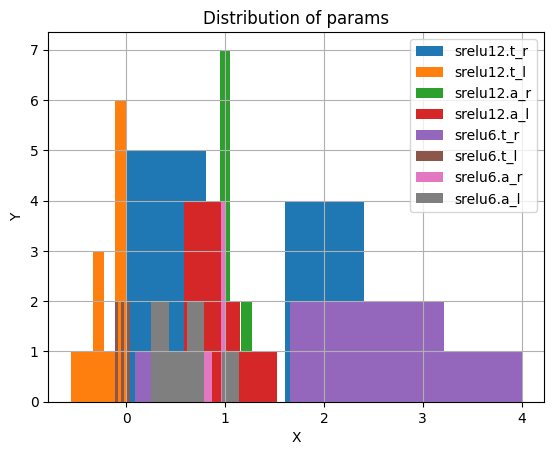

In [18]:
# We enter the parameters in our model and we save the SReLU ones into a list
# Later, we plot them through the hist() function.
param = []
for n, p in cnn.named_parameters():
  if (n.startswith("srelu")):
    ll = [0,""]
    print(F"Name: {n} | {p.shape}")
    print(p)
    ll[0] = p.data.cpu().detach().numpy().tolist()
    ll[1] = n
    param.append(ll)
    print("----------------")

figure = plt.figure(dpi=100)
figure.set_tight_layout(False)

for p in param:
  plt.hist(p[0], label=p[1], bins=5)   

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of params")
plt.legend(loc='upper right')
plt.grid(visible=True)
plt.show()

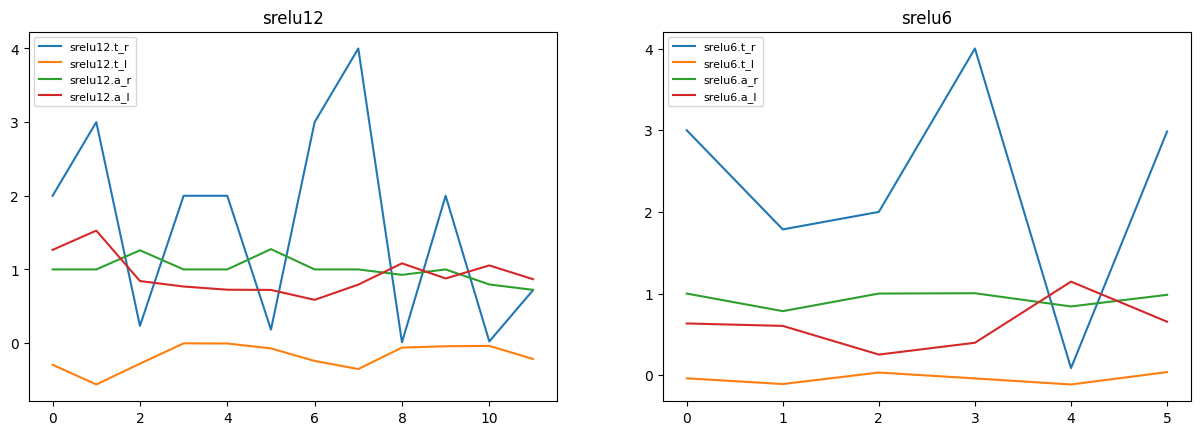

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(15)
axs_idx = 0

axs[0].set_title('srelu12')
axs[1].set_title('srelu6')

for p in param:   
    axs_idx = 0 if p[1].startswith("srelu12") else 1
    
    lenght = np.arange(0,len(p[0]),1)
    
    l1 = axs[axs_idx].plot(lenght, p[0], label=p[1])
    
    axs[axs_idx].grid()
    axs[axs_idx].legend(loc='upper left', prop={'size': 8.00})

    axs_idx += 1

plt.show()

## Final checklist
1. Carefully check all code. Insert comments when needed. Search for "TODO" to see if you forgot something.
2. Run everything one final time. *Please do not send us notebooks with errors or cells that are not working.*
3. Upload the completed notebook **before 30/11/2021 23:59** on the Google Classrom page.

### References

[1] Apicella, A., Donnarumma, F., Isgrò, F. and Prevete, R., 2021. [A survey on modern trainable activation functions](https://arxiv.org/abs/2005.00817).

[2] Jin, X., Xu, C., Feng, J., Wei, Y., Xiong, J. and Yan, S., 2016. [Deep learning with s-shaped rectified linear activation units](https://arxiv.org/abs/1512.07030). In Proceedings of the AAAI Conference on Artificial Intelligence (Vol. 30, No. 1).